<a href="https://colab.research.google.com/github/MUHAMMADALYAN/Sequences-Time-Series-and-Prediction/blob/master/Using_Multi_layer_NN_for_predicting_Time_Series_and_Optimizing_learning_rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

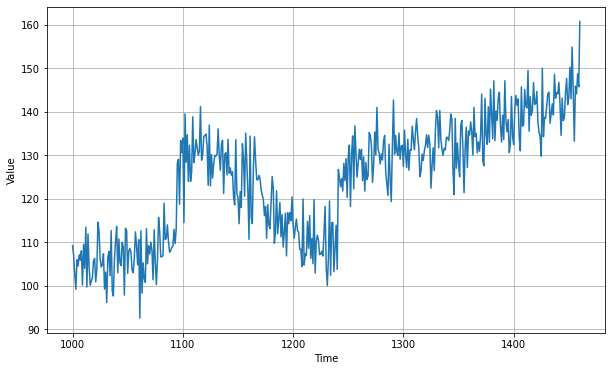

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


# In this case we take a window size data(=month ,year) for training and next value as label throughout training data as it is not traditional datsets

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)# =1 for label
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))# converting data window into features and next to  labels
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)# training dataset with 20 feature arrays and 1 label arrays


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)#training with 20 features = window size and next as label at a time


#Predicting

###It will take each window of 20 features and give us perdicted value with of learned weight by pattern in training 
series go from(1:21) give us label,(2:22) taking one window each time in this case.

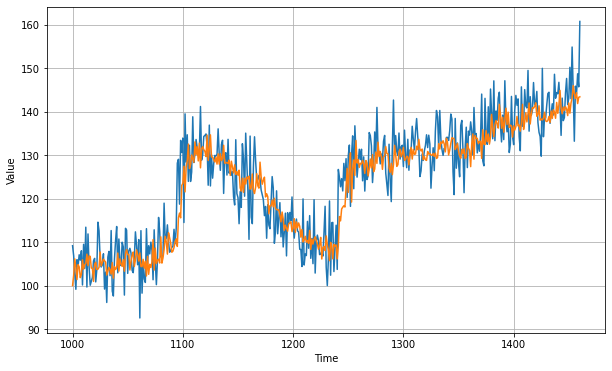

In [0]:
forecast = []
# window size will be minus from series as we want plot forecast for everypoint on time series relative to 20 points before (equal to window size)
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))#it will go from(1:21) give us label,(2:22) taking one window each time in this case.
# we  will retrain it on training and validation again it is because validation data is the closest data to the current point of time 
forecast = forecast[split_time-window_size:] # but we only forecast for validation data
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.6415124

# Training with different learning rates 
# Getting optimal learning rate by using call back ftn 

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

### Plotting loss per epoch against learning rate per epoch

(1e-08, 0.001, 0.0, 300.0)

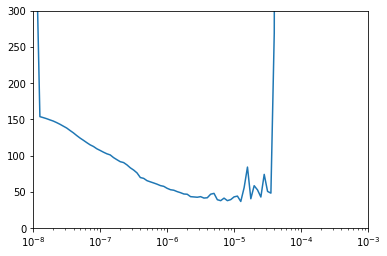

In [0]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [0]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

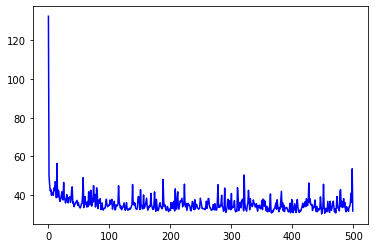

In [0]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[42.32877731323242, 46.9194450378418, 46.23613357543945, 38.6361083984375, 56.300048828125, 39.018802642822266, 42.59846115112305, 41.9957275390625, 37.988033294677734, 36.73405838012695, 38.00197982788086, 39.47377014160156, 41.71166229248047, 37.96064376831055, 37.461036682128906, 46.564205169677734, 38.2575798034668, 38.096343994140625, 35.92680740356445, 36.914852142333984, 40.29129409790039, 38.786376953125, 36.01604080200195, 38.61896896362305, 38.778076171875, 39.12617492675781, 36.21432876586914, 37.16816711425781, 42.25490951538086, 44.27863311767578, 35.72252655029297, 36.376708984375, 34.021610260009766, 35.19515609741211, 35.36663055419922, 36.41332244873047, 36.88600158691406, 37.276119232177734, 34.73826217651367, 36.23068618774414, 34.534629821777344, 33.97476577758789, 33.32008743286133, 33.899845123291016, 35.47748565673828, 35.61457824707031, 39.90144729614258, 49.02350616455078, 33.5423469543457, 36.87968063354492, 39.24604415893555, 35.3999137878418, 35.893051147460

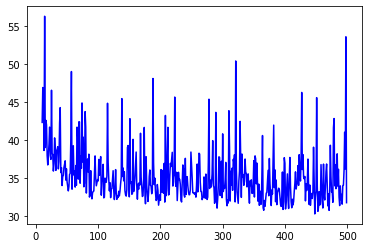

In [0]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

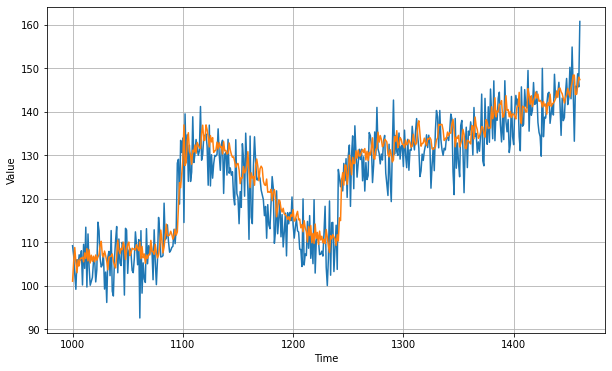

In [0]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.744276